# seasonal decomposition

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  # datetime converter for a matplotlib
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

## trends in atmospheric carbon dioxide

Mauna Loa CO2 concentration.  
data from [NOAA](https://gml.noaa.gov/ccgg/trends/data.html)

In [6]:
url = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_weekly_mlo.csv"
df = pd.read_csv(url, header=47, na_values=[-999.99])

# you can first download, and then read the csv
# filename = "co2_weekly_mlo.csv"
# df = pd.read_csv(filename, header=47, na_values=[-999.99])

df


,year,month,day,decimal,average,ndays,1 year ago,10 years ago,increase since 1800
0,1974,5,19,1974.3795,333.37,5,NaN,NaN,50.40
1,1974,5,26,1974.3986,332.95,6,NaN,NaN,50.06
2,1974,6,2,1974.4178,332.35,5,NaN,NaN,49.60
3,1974,6,9,1974.4370,332.20,7,NaN,NaN,49.65
4,1974,6,16,1974.4562,332.37,7,NaN,NaN,50.06
...,...,...,...,...,...,...,...,...,...
2510,2022,6,26,2022.4836,420.31,7,418.14,395.36,138.71
2511,2022,7,3,2022.5027,419.73,6,417.49,395.15,138.64
2512,2022,7,10,2022.5219,419.08,6,417.25,394.59,138.52
2513,2022,7,17,2022.5411,418.43,6,417.14,394.64,138.41


In [7]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.set_index('date')
df

,year,month,day,decimal,average,ndays,1 year ago,10 years ago,increase since 1800
date,,,,,,,,,
1974-05-19,1974,5,19,1974.3795,333.37,5,NaN,NaN,50.40
1974-05-26,1974,5,26,1974.3986,332.95,6,NaN,NaN,50.06
1974-06-02,1974,6,2,1974.4178,332.35,5,NaN,NaN,49.60
1974-06-09,1974,6,9,1974.4370,332.20,7,NaN,NaN,49.65
1974-06-16,1974,6,16,1974.4562,332.37,7,NaN,NaN,50.06
...,...,...,...,...,...,...,...,...,...
2022-06-26,2022,6,26,2022.4836,420.31,7,418.14,395.36,138.71
2022-07-03,2022,7,3,2022.5027,419.73,6,417.49,395.15,138.64
2022-07-10,2022,7,10,2022.5219,419.08,6,417.25,394.59,138.52


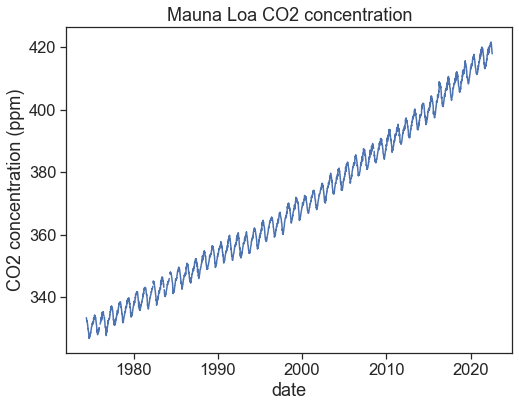

In [8]:
# %matplotlib widget

fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(df['average'])
ax.set(xlabel="date",
       ylabel="CO2 concentration (ppm)",
       # ylim=[0, 430],
       title="Mauna Loa CO2 concentration");

fill missing data. interpolate method: 'time'  
[interpolation methods visualized](https://thepythonyouneed.com/how-to-interpolate-values-with-pandas/)

In [9]:
df['co2'] = (df['average'].resample("D") #resample daily
                          .interpolate(method='time') #interpolate by time
            )
df

,year,month,day,decimal,average,ndays,1 year ago,10 years ago,increase since 1800,co2
date,,,,,,,,,,
1974-05-19,1974,5,19,1974.3795,333.37,5,NaN,NaN,50.40,333.37
1974-05-26,1974,5,26,1974.3986,332.95,6,NaN,NaN,50.06,332.95
1974-06-02,1974,6,2,1974.4178,332.35,5,NaN,NaN,49.60,332.35
1974-06-09,1974,6,9,1974.4370,332.20,7,NaN,NaN,49.65,332.20
1974-06-16,1974,6,16,1974.4562,332.37,7,NaN,NaN,50.06,332.37
...,...,...,...,...,...,...,...,...,...,...
2022-06-26,2022,6,26,2022.4836,420.31,7,418.14,395.36,138.71,420.31
2022-07-03,2022,7,3,2022.5027,419.73,6,417.49,395.15,138.64,419.73
2022-07-10,2022,7,10,2022.5219,419.08,6,417.25,394.59,138.52,419.08


## decompose data
`seasonal_decompose` returns an object with four components:

* observed: $Y(t)$
* trend: $T(t)$
* seasonal: $S(t)$
* resid: $e(t)$

Additive model:
$$
Y(t) = T(t) + S(t) + e(t)
$$

Multiplicative model:
$$
Y(t) = T(t) \times S(t) \times e(t)
$$

#### Interlude
learn how to use `zip` in a loop

In [10]:
letters = ['a', 'b', 'c', 'd', 'e']
numbers = [1, 2, 3, 4, 5]
# zip let's us iterate over to lists at the same time
for l, n in zip(letters, numbers):
    print(f"{l} = {n}")

a = 1
b = 2
c = 3
d = 4
e = 5


Plot each component separately.

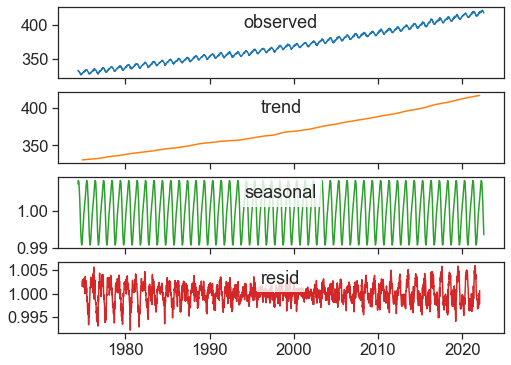

In [11]:
# %matplotlib widget

fig, ax = plt.subplots(4, 1, figsize=(8,6), sharex=True)
decomposed_m = seasonal_decompose(df['co2'], model='multiplicative')
decomposed_a = seasonal_decompose(df['co2'], model='additive')
decomposed = decomposed_m
pos = (0.5, 0.9)
components =["observed", "trend", "seasonal", "resid"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for axx, component, color in zip(ax, components, colors):
    data = getattr(decomposed, component)
    axx.plot(data, color=color)
    axx.text(*pos, component, bbox=dict(facecolor='white', alpha=0.8),
           transform=axx.transAxes, ha='center', va='top')

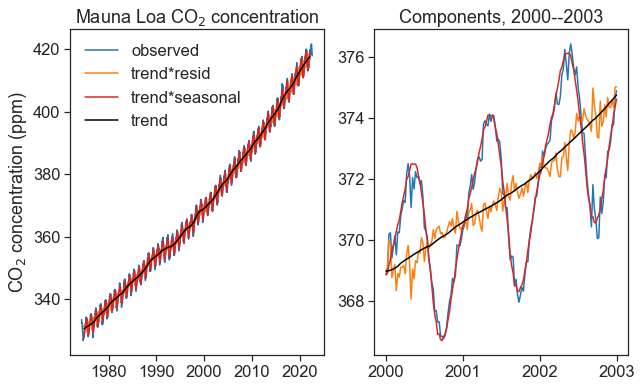

In [34]:
# %matplotlib widget

decomposed = decomposed_m

fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].plot(df['co2'], color="tab:blue", label="observed")
ax[0].plot(decomposed.trend * decomposed.resid, color="tab:orange", label="trend*resid")
ax[0].plot(decomposed.trend * decomposed.seasonal, color="tab:red", label="trend*seasonal")
ax[0].plot(decomposed.trend, color="black", label="trend")
ax[0].set(ylabel="CO$_2$ concentration (ppm)",
          title="Mauna Loa CO$_2$ concentration")
ax[0].legend(frameon=False)

start = "2000-01-01"
end = "2003-01-01"
zoom = slice(start, end)
ax[1].plot(df.loc[zoom, 'co2'], color="tab:blue", label="observed")
ax[1].plot((decomposed.trend * decomposed.resid)[zoom], color="tab:orange", label="trend*resid")
ax[1].plot((decomposed.trend * decomposed.seasonal)[zoom], color="tab:red", label="trend*seasonal")
ax[1].plot(decomposed.trend[zoom], color="black", label="trend")
date_form = DateFormatter("%Y")
ax[1].xaxis.set_major_formatter(date_form)
ax[1].xaxis.set_major_locator(mdates.YearLocator(1))
ax[1].set_title("Components, 2000--2003");
